Found 1289 images belonging to 2 classes.
Found 1289 images belonging to 2 classes.
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.6983 - loss: 0.5751 - val_accuracy: 0.4569 - val_loss: 0.7064
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9315 - loss: 0.2237 - val_accuracy: 0.4569 - val_loss: 0.7325
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9761 - loss: 0.0844 - val_accuracy: 0.4569 - val_loss: 0.7344
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9864 - loss: 0.0454 - val_accuracy: 0.4569 - val_loss: 0.8173
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9898 - loss: 0.0469 - val_accuracy: 0.4569 - val_loss: 0.9117
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9870 - loss: 0.0461 - val_accuracy: 0.5733 - val_loss: 0.6201
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9931 - loss: 0.0205 - val_accuracy: 0.9511 - val_loss: 0.1285
Epoch 8/10
41/41 ━━

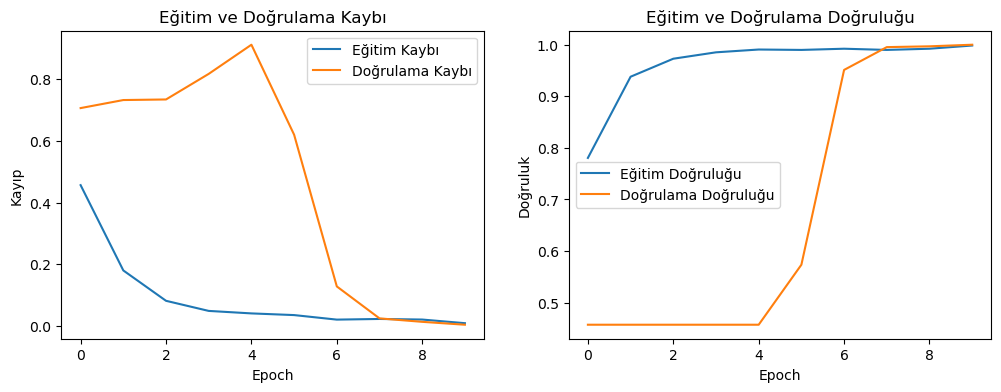

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Reshape, Dense, Multiply, Input, Layer, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

class ShuffleUnit(Layer):
    def __init__(self, groups, **kwargs):
        super(ShuffleUnit, self).__init__(**kwargs)
        self.groups = groups

    def call(self, x):
        height, width, channels = x.shape[1:]
        group_channels = channels // self.groups
        x = tf.reshape(x, [-1, height, width, self.groups, group_channels])
        x = tf.transpose(x, [0, 1, 2, 4, 3])
        x = tf.reshape(x, [-1, height, width, channels])
        return x

class SEUnit(Layer):
    def __init__(self, bottleneck_ratio=2, **kwargs):
        super(SEUnit, self).__init__(**kwargs)
        self.bottleneck_ratio = bottleneck_ratio

    def build(self, input_shape):
        input_channels = input_shape[-1]
        bottleneck_channels = input_channels // self.bottleneck_ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1, 1, input_channels))
        self.conv1 = Conv2D(bottleneck_channels, (1, 1), activation='relu', use_bias=False)
        self.conv2 = Conv2D(input_channels, (1, 1), activation='sigmoid', use_bias=False)

    def call(self, x):
        se = self.global_avg_pool(x)
        se = self.reshape(se)
        se = self.conv1(se)
        se = self.conv2(se)
        x = Multiply()([x, se])
        return x

class ShuffleNetV2Block(Layer):
    def __init__(self, out_channels, kernel_size, strides=1, dilation_rate=1, shuffle_groups=2, **kwargs):
        super(ShuffleNetV2Block, self).__init__(**kwargs)
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.dilation_rate = dilation_rate
        self.shuffle_groups = shuffle_groups

    def build(self, input_shape):
        self.conv1 = Conv2D(self.out_channels // 2, 1, strides=1, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        
        self.depthwise_conv = DepthwiseConv2D(self.kernel_size, strides=self.strides, padding='same', dilation_rate=self.dilation_rate, use_bias=False)
        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()
        
        self.conv2 = Conv2D(self.out_channels // 2, 1, strides=1, padding='same', use_bias=False)
        self.bn3 = BatchNormalization()
        self.relu3 = ReLU()

        self.shuffle_unit = ShuffleUnit(self.shuffle_groups)

    def call(self, x):
        input_channels = x.shape[-1]
        
        if self.strides == 1:
            half_channels = self.out_channels // 2
            top, bottom = tf.split(x, 2, axis=-1)

            top = self.conv1(top)
            top = self.bn1(top)
            top = self.relu1(top)

            top = self.depthwise_conv(top)
            top = self.bn2(top)
            top = self.relu2(top)

            top = self.conv2(top)
            top = self.bn3(top)
            top = self.relu3(top)

            x = tf.concat([top, bottom], axis=-1)
        else:
            half_channels = self.out_channels // 2
            b0 = self.conv1(x)
            b0 = self.bn1(b0)
            b0 = self.relu1(b0)

            b0 = self.depthwise_conv(b0)
            b0 = self.bn2(b0)
            b0 = self.relu2(b0)

            b0 = self.conv2(b0)
            b0 = self.bn3(b0)
            b0 = self.relu3(b0)

            b1 = self.depthwise_conv(x)
            b1 = self.bn2(b1)
            b1 = self.relu2(b1)

            b1 = self.conv2(b1)
            b1 = self.bn3(b1)
            b1 = self.relu3(b1)

            x = tf.concat([b0, b1], axis=-1)
        
        x = self.shuffle_unit(x)
        return x

def build_shufflenet_v2(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = conv_bn_relu(inputs, 24, 3, strides=2)
    x = ShuffleNetV2Block(48, 3, strides=2)(x)
    x = ShuffleNetV2Block(96, 3, strides=2)(x)
    x = ShuffleNetV2Block(192, 3, strides=2)(x)
    x = ShuffleNetV2Block(384, 3, strides=2)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

def conv_bn_relu(x, out_channels, kernel_size, strides=1, dilation_rate=1):
    x = Conv2D(out_channels, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


input_shape = (64, 64, 3)
num_classes = 2  
model = build_shufflenet_v2(input_shape, num_classes)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory('C:\\Users\\Lenovo\\Desktop\\CNNprojeleri\\HARDfakevsreal',
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('C:\\Users\\Lenovo\\Desktop\\CNNprojeleri\\HARDfakevsreal',
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode='binary')

history = model.fit(training_set, epochs=10, validation_data=test_set)


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()
